In [1]:
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt

def get_data(start, end, country_code='DE'):

    turnover_dates = [datetime.date(2017, 9, 26), datetime.date(2016, 9, 20), datetime.date(2015, 9, 22), 
                      datetime.date(2014, 9, 23), datetime.date(2013, 10, 15), datetime.date(2012, 10, 9),
                      datetime.date(2011, 10, 11), datetime.date(2010, 10, 12), datetime.date(2009, 10, 13),
                      datetime.date(2008, 10, 14), datetime.date(2007, 10, 9), datetime.date(2006, 10, 10)]

    # yields date and olc_year
    def daterange(start_date, end_date):
        if start_date <= end_date:
            for n in range((end_date - start_date ).days + 1):
                date = start_date + datetime.timedelta(n)
                yield date, 2018 - turnover_dates.index(next(i for i in turnover_dates if date >= i))  
        else:
            for n in range((start_date - end_date ).days + 1):
                date = start_date - datetime.timedelta(n)
                yield date, 2018 - turnover_dates.index(next(i for i in turnover_dates if date >= i))  

    # first day of olc records
    if end < datetime.date(2006, 10, 10):
        end = datetime.date(2006, 10, 10)

    # array to store all the flights   
    flights = []

    # iterate through dates
    for date, olc_year in daterange(start, end):

        # specify the url
        begin = 'https://www.onlinecontest.org/olc-2.0/gliding/daily.html?st=olc&rt=olc&df='
        middle1 = '&sp='
        middle2 = '&c='
        end = '&sc='
        quote_page = begin + str(date) + middle1 + str(olc_year) + middle2 + country_code + end

        # print link
        print(quote_page)

        # query the website and return the html to the variable ‘page’
        page = urllib.request.urlopen(quote_page)

        # parse the html using beautiful soup and store in variable `soup`
        soup = BeautifulSoup(page, 'html.parser')

        # Take out the <div> of list and get its value
        table = soup.find('table', attrs={'class': 'list'})

        # iterate through table
        trs = table.findAll('tr', attrs={'class': 'valid'})
        for tr in trs:
            tds = tr.findAll('td', class_=lambda x: x!= 'lupe')
            flight=[str(date)]
            for i, td in zip(range(len(tds)),tds):
                string = td.text.strip().replace(u'\xa0', u' ')

                # no fai before this date
                if date <= datetime.date(2010, 10, 11):
                    if i in [2, 6, 7, 8]:
                        flight.append(string)
                    if i in [0, 1, 4, 5, 9, 10]:
                        string = string.replace('.', '')
                        string = string.replace(':', '.')
                        string = string.replace(',', '.')
                        flight.append(float(string))

                    # 0 value for FAI
                    if i == 4:
                        flight.append(float(0))

                # fai box
                else:
                    if i in [2, 7, 8, 9]:
                        flight.append(string)
                    if i in [0, 1, 4, 5, 6, 10, 11]:
                        string = string.replace('.', '')
                        string = string.replace(':', '.')
                        string = string.replace(',', '.')
                        flight.append(float(string))

            # append flight to matrix           
            flights.append(flight)

        # wait for 0.1 seconds to be soft on the website
        time.sleep(0.1)
    return flights


# finds the average points of the first five flights on a day based on olc records
def find_best_days(flights_table, country=None):
    if country:
        flights_table = flights_table[flights_table['Airfield'].str.contains(country + ' /')]
    
    # matrix to store average points
    average_points = np.zeros((365))
    
    # years to evaluate
    years = np.arange(2007, 2018)
    
    # loop through years
    for year in years:
        base = datetime.date(year, 1, 1)
        date_list = [base + datetime.timedelta(days=x) for x in range(0, 365)]
        
        # loop through dates
        for i, date in zip(range(len(date_list)), date_list):
            
            # filter flights
            flights_on_day = flights_table.loc[flights_table['Date'].str.contains(str(date))]
            
            # use five flights if possible
            if flights_on_day.shape[0] >= 5:
                average_points[i] += (flights_on_day['Points'][0:5].mean())
                
            if flights_on_day.shape[0] == 0:
                average_points[i] += 0
                
            # if not, use what you have
            if (flights_on_day.shape[0] > 0 and flights_on_day.shape[0] < 5):
                average_points[i] += (flights_on_day['Points'].mean())
                
    average_points = average_points / len(years)
    return average_points

In [ ]:
flights = get_Data(datetime.date(year = 2018, month = 1, day = 1), 
                  datetime.date(year = 2006, month = 10, day = 10))

# create Pandas DataFrame
flights_table = pd.DataFrame(flights, columns = ['Date', 'Score', 'Points', 'Pilot', 'Km', 'FAI', 'Speed',
                                                 'Airfield', 'Club', 'Glider', 'Start', 'Land'])
print(flights_table.info())

In [72]:
# save the flights
flights_table.to_csv('flights_table_DE', sep='\t')
flights_table.to_pickle('flights_table_DE.pkl')

In [2]:
# load the flights
flights_table = pd.read_pickle('flights_table_DE.pkl')

In [3]:
# how many different Glider types?
flights_table.Glider.nunique()

374

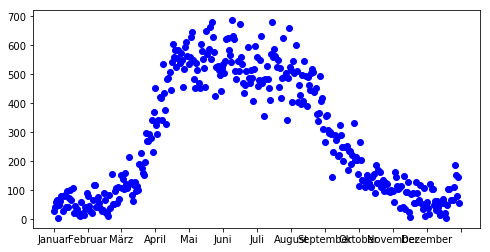

In [4]:
best_days = find_best_days(flights_table)

plt.figure(1)
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, 366), best_days, 'bo')

# different month length not accounted for
plt.xticks(np.linspace(1, 366, 13), ('Januar', 'Februar', 'März', 'April', 'Mai', 'Juni', 'Juli', 'August', 
                        'September', 'Oktober', 'November', 'Dezember', ''))

plt.show()
